## Transfer learning
Transfer learning (uczenie transferowe) to technika uczenia maszynowego, w której wykorzystuje się już wytrenowany model do rozwiązania innego zadania lub problemu, niż ten dla którego był pierwotnie stworzony.

Idea ta wynika z faktu, że wiele złożonych modeli uczenia maszynowego wymaga ogromnej ilości danych treningowych oraz czasu i zasobów obliczeniowych, aby zostać skutecznie wytrenowanymi. W niektórych przypadkach, takie zasoby mogą być ograniczone lub trudne do zdobycia.

Wykorzystanie transfer learning pozwala uniknąć konieczności treningu całego modelu od podstaw i pozwala na wykorzystanie już istniejących modeli, które zostały wytrenowane na dużych zbiorach danych. Dzięki temu, model może być dostosowany do nowego zadania z mniejszą ilością danych treningowych i krótszym czasem treningu.

Technika ta polega na pobraniu istniejącego modelu wytrenowanego na dużym zbiorze danych (np. ImageNet) i dostosowaniu go do nowego problemu przez zamrożenie jednej lub kilku warstw, a następnie przystosowanie pozostałych warstw do nowego zbioru danych poprzez trening na mniejszej liczbie epok.

Transfer learning jest stosowany w wielu dziedzinach, w tym w przetwarzaniu obrazów, języka naturalnego, rozpoznawaniu mowy, detekcji obiektów, itp.

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time
import matplotlib.pyplot as plt
#from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
#from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import os

# Read csv data files
train_data = pd.read_csv('./input/fashion-mnist_train.csv')
test_data = pd.read_csv('./input/fashion-mnist_test.csv')

# train_data

train_data.shape #(60,000*785)
test_data.shape #(10000,785)

train_X= np.array(train_data.iloc[:,1:])
test_X= np.array(test_data.iloc[:,1:])
train_Y= np.array (train_data.iloc[:,0]) # (60000,)
test_Y = np.array(test_data.iloc[:,0]) #(10000,)

# train_data.head()
# train_X.shape, test_X.shape

classes = np.unique(train_Y)
num_classes = len(classes)
# num_classes

# Convert the images into 3 channels
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X]*3)
# train_X.shape,test_X.shape

# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
# train_X.shape,test_X.shape

# Resize the images 48*48 as required by VGG16
from keras.utils import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
#train_x = preprocess_input(x)
# train_X.shape, test_X.shape

# Normalise the data and change data type
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

# Converting Labels to one hot encoded format
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Splitting train data as train and validation data
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

# Preprocessing the input
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)


# Finally check the data size whether it is as per tensorflow and VGG16 requirement
train_X.shape, train_label.shape, valid_X.shape, valid_label.shape


((48000, 48, 48, 3), (48000, 10), (12000, 48, 48, 3), (12000, 10))

In [10]:

from keras.models import Sequential, Model

# Define the parameters for instanitaing VGG16 model.
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16


#  Create base model of VGG16
# conv_base = VGG16(weights='../input/keras-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
conv_base = VGG16(include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                  )

# Extracting features
train_features = conv_base.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)


for layer in conv_base.layers:
   layer.trainable = False


# dodanie nowych warstw
x = Flatten()(conv_base.output)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

# utworzenie nowego modelu z wstępnie wytrenowanym modelem VGG16 i nowymi warstwami
model = Model(inputs=conv_base.input, outputs=output)

# kompilacja modelu
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# predykcja na zbiorze testowym
# predictions = model.predict(np.array(test_X))

model.summary()



2023-03-06 16:21:11.638827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 14s 18ms/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 b

In [17]:
# Flatten extracted features
# train_features_flat = np.reshape(train_features, (48000, 1*1*512))
# test_features_flat = np.reshape(test_features, (10000, 1*1*512))
# val_features_flat = np.reshape(val_features, (12000, 1*1*512))


# trenowanie nowego modelu tylko dla nowych warstw
history = model.fit(np.array(train_X), train_label, epochs=10)

score = model.evaluate(np.array(test_X), verbose=1)

print('===========================')
print('>>>> Test Loss : {:.4f}'.format(score[0]))
print('>>>> Test Accuracy : {:.4f}'.format(score[1]))
print('===========================\n\n')



Epoch 1/10


ValueError: in user code:

    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/losses.py", line 2084, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras/backend.py", line 5630, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(320,) and logits.shape=(32, 10)


In [14]:
train_X.shape


(48000, 48, 48, 3)

In [25]:
train_Y

array([2, 9, 6, ..., 8, 8, 7])

In [14]:
test_Y_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)
Epoch 1/30


2023-02-27 17:13:25.286233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1498/1500 [============================>.] - ETA: 0s - loss: 1.4522 - acc: 0.4620

2023-02-27 17:13:40.746078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1500/1500 [==============================] - 19s 12ms/step - loss: 1.4519 - acc: 0.4622 - val_loss: 1.2131 - val_acc: 0.5723 - lr: 0.0010
Epoch 2/30
1500/1500 [==============================] - 16s 11ms/step - loss: 1.0910 - acc: 0.6008 - val_loss: 1.0110 - val_acc: 0.6120 - lr: 0.0010
Epoch 3/30
1500/1500 [==============================] - 16s 11ms/step - loss: 0.9855 - acc: 0.6409 - val_loss: 0.9611 - val_acc: 0.6564 - lr: 0.0010
Epoch 4/30
1500/1500 [==============================] - 16s 11ms/step - loss: 0.9381 - acc: 0.6557 - val_loss: 0.9617 - val_acc: 0.6359 - lr: 0.0010
Epoch 5/30
1500/1500 [==============================] - 15s 10ms/step - loss: 0.9000 - acc: 0.6699 - val_loss: 0.9248 - val_acc: 0.6587 - lr: 0.0010
Epoch 6/30
1500/1500 [==============================] - 17s 11ms/step - loss: 0.8772 - acc: 0.6788 - val_loss: 0.8781 - val_acc: 0.6785 - lr: 0.0010
Epoch 7/30
1500/1500 [==============================] - 21s 14ms/step - loss: 0.8665 - acc: 0.6812 - val_loss: 0.8544

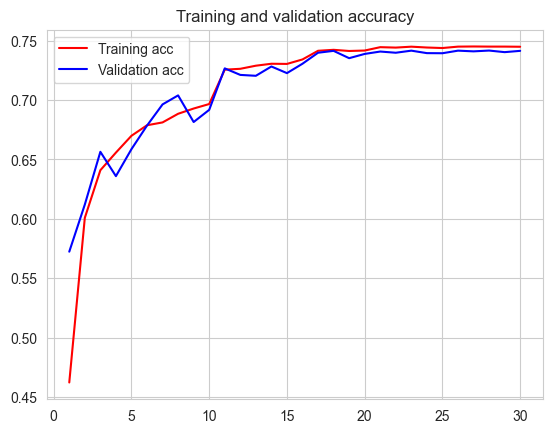

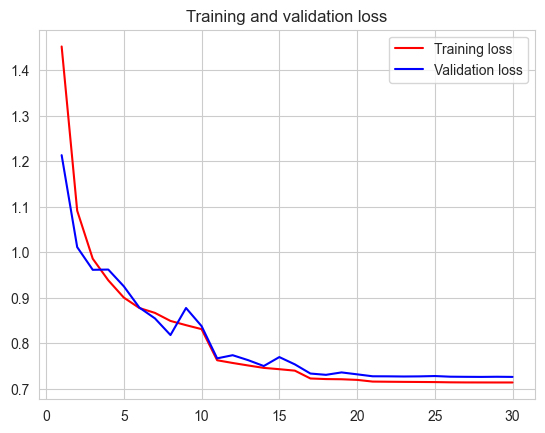

In [8]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers import LeakyReLU

# 6.1 Saving the features so that they can be used for future
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, test_Y)
np.savez("val_features", val_features, valid_label)

# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

# 7.0 Define the densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 30

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

# Train the the model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

# plot the loss and accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

References
https://www.kaggle.com/crawford/diagnose-lung-disease-with-vgg16
https://www.programcreek.com/python/example/92213/keras.applications.vgg16.VGG16
http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html